In [3]:
library(circlize)


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [4]:
data_start_end

factor,start,end
<int>,<dbl>,<dbl>
1,0,4
2,4,6
3,6,7
4,7,16
5,16,21
6,21,28
7,28,30
8,30,31
9,31,32


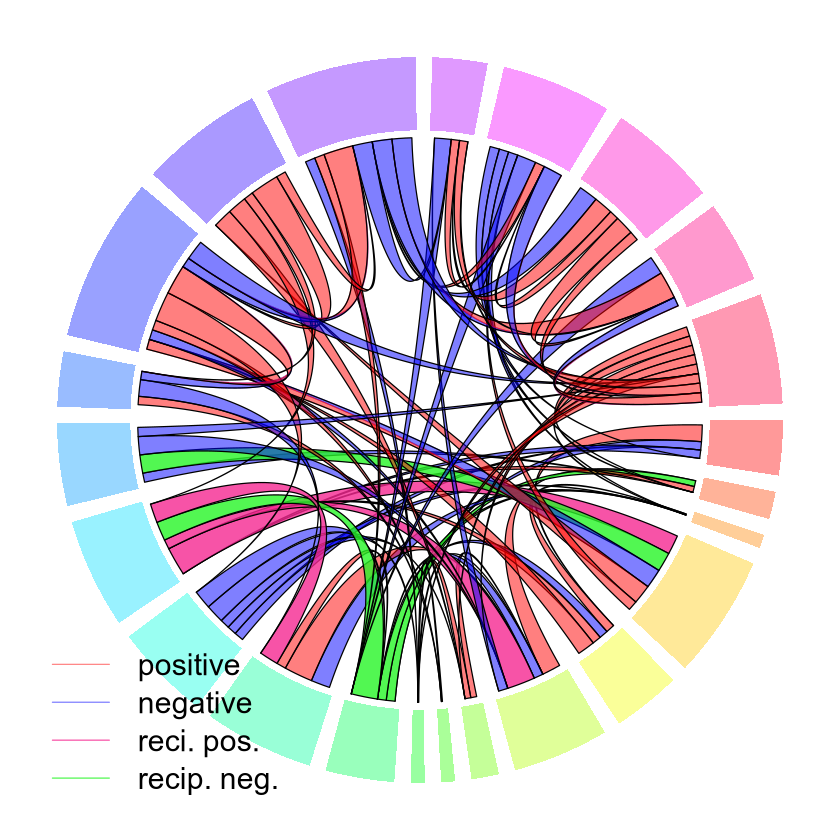

In [7]:
# create a matrix [0,1,2; 2,0,-1, -1,1,0]
mat = matrix(c(0,1,2, 2,0,-1, -1,1,0), nrow = 3, ncol = 3, byrow = TRUE)

# create a random matrix of size 10x10 that contains integers between -5 and 5 and 0 on the diagonal
mat = matrix(sample(c(-5:5,0), 100, replace = TRUE), nrow = 10, ncol = 10)
diag(mat) = 0

# read the matrix from a file
mat = read.table("matrix_decoded.csv", sep=";")
mat = as.matrix(mat
                )

# create a vector of integers from 1 to the number of rows of the matrix
items = 1:nrow(mat)

# create a vector of cumulative sums of the absolute values of the rows of the matrix, starting with 0
v1 = c(0, cumsum(apply(mat, 1, function(x) sum(abs(x)))))


# create a data frame that contains, for each item, one row for the start of the arc
# and one row for the end of the arc, using the vector of cumulative sums to determine the start and end points
df = data.frame(
    factor = rep(items, each = 2),
    x = rep(v1, each = 2)[2:(2*length(v1)-1)]
    )

# Create an auxuliary data frame that contains, for each item, the start and end points of the arc
data_start_end = data.frame(
    factor = items,
    start = v1[1:length(v1)-1],
    end = v1[2:length(v1)]
    )



# Initialize the plot.
par(mar = c(1, 1, 1, 1) ) 
total_gap = 60
gap_degree = total_gap /nrow(mat)
circos.par(gap.degree = gap_degree)
circos.initialize(factors = df$factor, x = df$x)


# Create a vector of N distinct colors (N = number of rows of the matrix) using pastel colors
cols = rainbow(nrow(mat), s = 1, v = 1, alpha = 0.4)

red = rgb(1,0,0,0.5)
blue = rgb(0,0,1,0.5)
pink = rgb(245/255, 40/255, 145/255, 0.8)
green = rgb(39/255, 245/255, 39/255, 0.8)

# Build the regions of track #1
circos.trackPlotRegion(factors = df$factor, ylim = c(0,1) ,bg.col = cols, bg.border = NA, 
    )



for (i in 1:nrow(mat)){
    i0 = data_start_end$start[i] # start of the arc at the source


    for (j in i:ncol(mat)) {
        if (i == j) next # skip the diagonal
        # print the source and target
        j0 = data_start_end$start[j] # start of the arc at the target
        width_ij = abs(mat[i,j])
        width_ji = abs(mat[j,i])


        # color is red for positive values, blue for negative values, black for 0
        col_ij = ifelse(mat[i,j] > 0, red, ifelse(mat[i,j] < 0, blue, "black"))
        col_ji = ifelse(mat[j,i] > 0, red, ifelse(mat[j,i] < 0, blue, "black"))

        if (col_ij == col_ji & col_ij == red) {
            col_ij = col_ji = pink
            circos.link(i, c(i0, i0+width_ij), j, c(j0, j0+width_ji), col = col_ij, lwd = 1, lty = 1, border="black" )
        } else if (col_ij == col_ji & col_ij == blue) {
            col_ij = col_ji = green
            circos.link(i, c(i0, i0+width_ij), j, c(j0, j0+width_ji), col = col_ij, lwd = 1, lty = 1, border="black" )
        } else {
            if (width_ij > 0 & width_ji > 0) {
                circos.link(i, c(i0, i0+width_ij), j, c(j0+width_ji, j0+width_ji), col = col_ij)
                circos.link(i, c(i0+width_ij, i0+width_ij), j, c(j0, j0+width_ji), col = col_ji)
                circos.link(i, c(i0, i0+width_ij), j, c(j0, j0+width_ji), col = rgb(0,0,0,0), lwd = 1, lty = 1, border="black" )

            } else if (width_ij > 0 | width_ji > 0) {
                # draw the arc if the value is not 0
                if (width_ij > 0) circos.link(i, c(i0, i0+width_ij), j, c(j0+width_ji, j0+width_ji), col = col_ij, lwd = 1, lty = 1, border="black" )
                if (width_ji > 0) circos.link(i, c(i0+width_ij, i0+width_ij), j, c(j0, j0+width_ji), col = col_ji, lwd = 1, lty = 1, border="black" )

            }
        }
        
        # update the start of the arc at the target
        data_start_end$start[j] = j0 + width_ji
        i0 = i0 + width_ij
    }
    data_start_end$start[i] = i0
}

legend("bottomleft", legend = c("positive", "negative", "reci. pos.", "recip. neg."), col = c(red, blue, pink, green), lty = 1, lwd = 1, bty = "n", cex = 1.5)
circos.clear()
